<a href="https://colab.research.google.com/github/mr-jadeja/Banglore-Home-Price/blob/master/Medium_Imp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## for data
import json
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for processing
import re
import nltk

## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

## for word embedding
!pip install lime
from lime import lime_text
import gensim
import gensim.downloader as gensim_api

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

## for bert language model
!pip install transformers
import transformers

Importing Dataset

In [ ]:
df = pd.read_csv('/content/data.csv')
df.dropna(inplace=True)
df.isnull().sum()

Title         0
Summary       0
Enrollment    0
Stars         0
Rating        0
Link          0
Type          0
dtype: int64

In [ ]:
df["Description"] = df.apply(lambda row: row.Title + row.Summary, axis=1)
df.head()

,Title,Summary,Enrollment,Stars,Rating,Link,Type,Description
0,Retração de M5 pode te salvar,"O poder oculto das retrações de M5, tudo nos m...",16.0,3.9,6.0,https://www.udemy.com/course/retracao-de-m5-po...,Finance,Retração de M5 pode te salvarO poder oculto da...
1,Develop Opencv based Facial recognition system...,This course is specially designed for face det...,553.0,3.8,115.0,https://www.udemy.com/course/develop-opencv-ba...,Tech,Develop Opencv based Facial recognition system...
2,Learn Swift 4 - Apple's Latest Programming Lan...,Unofficially - The BEST and ONLY course on Ude...,1076.0,3.5,11.0,https://www.udemy.com/course/learn-swift-4-and...,Tech,Learn Swift 4 - Apple's Latest Programming Lan...
3,Wireframing & Prototyping Free Balsamiq Altern...,"Create website and application wireframes, pro...",200.0,3.7,38.0,https://www.udemy.com/course/wireframing/,Design,Wireframing & Prototyping Free Balsamiq Altern...
4,Complete Email Marketing Strategy Made Easy wi...,Learn email marketing strategy with subscriber...,356.0,4.2,78.0,https://www.udemy.com/course/how-to-do-complet...,Marketing,Complete Email Marketing Strategy Made Easy wi...


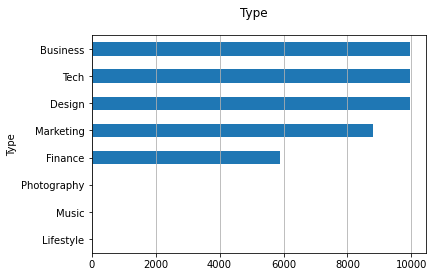

In [ ]:
fig, ax = plt.subplots()
fig.suptitle("Type", fontsize=12)
df["Type"].reset_index().groupby("Type").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

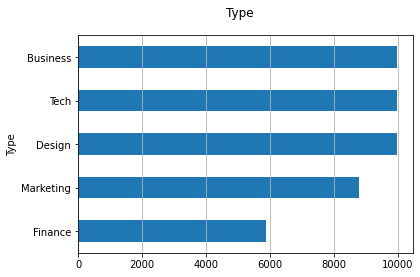

In [ ]:
# drop list courses for not getting conflict
index_names = df[ (df['Type'] == 'Photography') | (df['Type'] == 'Music') | (df['Type'] == 'Lifestyle')].index
  
# drop these given row
df.drop(index_names, inplace = True)
fig, ax = plt.subplots()
fig.suptitle("Type", fontsize=12)
df["Type"].reset_index().groupby("Type").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [ ]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and   
    ## characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
lst_stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df["text_clean"] = df['Description'].apply(
    lambda x: utils_preprocess_text(
        x,
        flg_stemm=False,
        flg_lemm=True,
        lst_stopwords=lst_stopwords,
    )
)
df.head()

,Title,Summary,Enrollment,Stars,Rating,Link,Type,Description,text_clean
0,Retração de M5 pode te salvar,"O poder oculto das retrações de M5, tudo nos m...",16.0,3.9,6.0,https://www.udemy.com/course/retracao-de-m5-po...,Finance,Retração de M5 pode te salvarO poder oculto da...,retração de m5 pode te salvaro poder oculto da...
1,Develop Opencv based Facial recognition system...,This course is specially designed for face det...,553.0,3.8,115.0,https://www.udemy.com/course/develop-opencv-ba...,Tech,Develop Opencv based Facial recognition system...,develop opencv based facial recognition system...
2,Learn Swift 4 - Apple's Latest Programming Lan...,Unofficially - The BEST and ONLY course on Ude...,1076.0,3.5,11.0,https://www.udemy.com/course/learn-swift-4-and...,Tech,Learn Swift 4 - Apple's Latest Programming Lan...,learn swift 4 apple latest programming languag...
3,Wireframing & Prototyping Free Balsamiq Altern...,"Create website and application wireframes, pro...",200.0,3.7,38.0,https://www.udemy.com/course/wireframing/,Design,Wireframing & Prototyping Free Balsamiq Altern...,wireframing prototyping free balsamiq alternat...
4,Complete Email Marketing Strategy Made Easy wi...,Learn email marketing strategy with subscriber...,356.0,4.2,78.0,https://www.udemy.com/course/how-to-do-complet...,Marketing,Complete Email Marketing Strategy Made Easy wi...,complete email marketing strategy made easy ma...


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dfle = df
df['Type'] = le.fit_transform(dfle['Type'])
Y = df['Type']
# ohe = OneHotEncoder(categorical_features = [0])

df.head()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text_clean'],df['Type'], stratify=df['Type'])

In [ ]:
y_train.head()

25342    1
16869    4
760      1
9356     4
22048    1
Name: Type, dtype: int64

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
# !pip install tensorflow_text
import tensorflow_text as text
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_4 (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [ ]:
len(X_train)

33420

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model.fit(X_train, y_train, epochs=20)

Epoch 1/20
  12/1045 [..............................] - ETA: 4:49:56 - loss: -1.7172 - accuracy: 0.2240 - precision: 0.7586 - recall: 0.9761

Split Dataset into train and test

In [ ]:
## split dataset
dtf_train, dtf_test = model_selection.train_test_split(df, test_size=0.33)
## get target
y_train = dtf_train["Type"].values
y_test = dtf_test["Type"].values

Classic CountVectorizer and TF-IDF

In [ ]:
## Count (classic BoW)
# vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [ ]:
corpus = dtf_train["text_clean"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

heatmap

Text(0.5, 1.0, 'Sparse Matrix Sample')

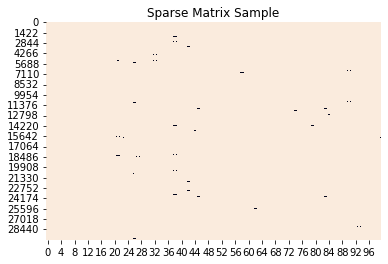

In [ ]:
sns.heatmap(
    X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, 
    vmin=0,
    vmax=1,
    cbar=False
).set_title('Sparse Matrix Sample')

In [ ]:
word = "python"
dic_vocabulary[word]

7285

Perform chi2 treat business 1 others 0 one by one

In [ ]:
from sklearn import feature_selection
y = dtf_train["Type"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")

# Business:
  . selected features: 1617
  . top features: agile,business,communication,de,ebay,employee,entrepreneurship,estate,home,leadership
 
# Design:
  . selected features: 1991
  . top features: 2d,3d,3d max,4d,adobe,adobe effect,adobe illustrator,adobe photoshop,animate,animation
 
# Finance:
  . selected features: 1235
  . top features: account,accounting,bitcoin,blockchain,bolsa,bolsa de,bookkeeping,credit,day trading,de
 
# Marketing:
  . selected features: 1734
  . top features: ad,advertising,adwords,affiliate,affiliate marketing,brand,campaign,content,content marketing,copywriting
 
# Tech:
  . selected features: 2208
  . top features: algorithm,android,angular,apache,api,apis,app,application,application using,apps
 


In [ ]:
# fit new model on the newly created vocabulary from chi2
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_


Text(0.5, 1.0, 'Sparse Matrix Sample')

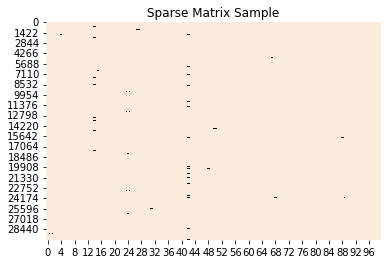

In [ ]:
sns.heatmap(
    X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, 
    vmin=0,
    vmax=1,
    cbar=False
).set_title('Sparse Matrix Sample')

In [ ]:
classifier = naive_bayes.MultinomialNB()

In [ ]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = dtf_test["text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.79
Auc: 0.96
Detail:
              precision    recall  f1-score   support

    Business       0.61      0.78      0.68      3212
      Design       0.91      0.84      0.87      3294
     Finance       0.76      0.55      0.64      1989
   Marketing       0.83      0.76      0.79      2843
        Tech       0.89      0.92      0.90      3368

    accuracy                           0.79     14706
   macro avg       0.80      0.77      0.78     14706
weighted avg       0.80      0.79      0.79     14706



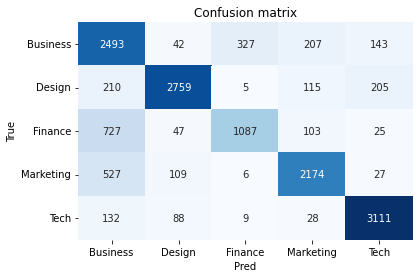

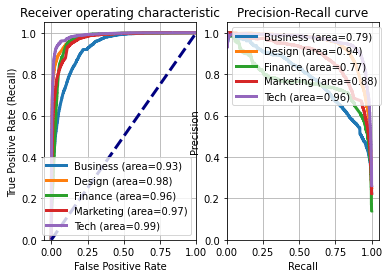

In [ ]:
from sklearn import metrics
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [ ]:
## select observation
i = 0
txt_instance = dtf_test['Description'].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=
             np.unique(y_train))
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: Business --> Pred: Business | Prob: 0.81


In [ ]:
corpus = dtf_train["text_clean"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [ ]:
## fit w2v
nlp = gensim.models.word2vec.Word2Vec(
    lst_corpus,
    size=300,
    window=8,
    min_count=1,
    sg=1,
    iter=30
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentat

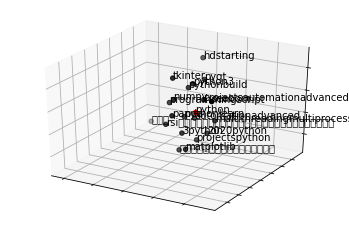

In [ ]:
word = "python"
fig = plt.figure()
## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 nlp.most_similar(word, topn=20)]
X = nlp[tot_words]
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1
## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

In [ ]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

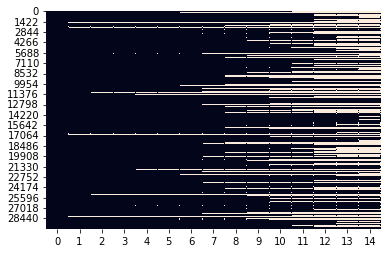

In [ ]:
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [ ]:
i = 54

## list of text: ["I like this", ...]
len_txt = len(dtf_train["text_clean"].iloc[i].split())
print("from: ", dtf_train["text_clean"].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", dtf_train["text_clean"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[dtf_train["text_clean"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")


from:  get invoice paid time every timeuse covid lockdown reset collection process restart customer relationship end late payment | len: 17
to:  [   26  4074   763   113   350 10954  4828  8506  6047  1528   122 17825
   127   838   449] | len: 15
check:  get  -- idx in vocabulary --> 26
vocabulary:  {'NaN': 1, 'course': 2, 'learn': 3, 'business': 4, 'marketing': 5} ... (padding element, 0)


In [ ]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass
embeddings

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.15393491, -0.35552421,  0.06486347, ..., -0.22183301,
         0.06356752, -0.40114093],
       ...,
       [-0.07281889, -0.2372749 ,  0.2162151 , ...,  0.06166963,
        -0.12340205, -0.00454429],
       [-0.15151636, -0.24338889,  0.23796684, ...,  0.02375707,
        -0.0470503 , -0.01285682],
       [-0.14155652, -0.23355737,  0.19829445, ...,  0.02469117,
        -0.04273728, -0.03243753]])

In [ ]:
word = "application"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 56 |idx
embeddings[idx]: (300,) |vector


In [ ]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x


## input
x_in = layers.Input(shape=(15,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=15)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)

## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(3, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 15)]         0           []                               
                                                                                                  
 embedding_11 (Embedding)       (None, 15, 300)      14708400    ['input_10[0][0]']               
                                                                                                  
 permute_3 (Permute)            (None, 300, 15)      0           ['embedding_11[0][0]']           
                                                                                                  
 dense_22 (Dense)               (None, 300, 15)      240         ['permute_3[0][0]']              
                                                                                            

In [ ]:
model.fit(X_train)


ValueError: ignored

In [ ]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## train
training = model.fit(x=X_train, y=y_train, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

ValueError: ignored

**BERT**

In [ ]:
txt = "bank river"
## bert tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
## bert model
nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')
## return hidden layer with embeddings
input_ids = np.array(tokenizer.encode(txt))[None,:]  
embedding = nlp(input_ids)
embedding[0][0]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


<tf.Tensor: shape=(4, 768), dtype=float32, numpy=
array([[-0.34245923,  0.0520041 , -0.2565382 , ..., -0.24441785,
         0.05279787,  0.44900617],
       [-0.38362488, -0.6671516 , -0.35021228, ..., -0.102105  ,
        -0.21629423, -0.2929996 ],
       [-0.34996074, -0.08316985, -0.9876831 , ...,  0.06963284,
        -0.49452975, -0.16088319],
       [ 0.7392341 ,  0.07391965, -0.45681012, ..., -0.02415758,
        -0.7649664 , -0.28110707]], dtype=float32)>

In [ ]:
## distil-bert tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
corpus = dtf_train["Description"]
maxlen = 50

## add special tokens
maxqnans = np.int((maxlen-20)/2)
corpus_tokenized = ["[CLS] "+
             " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
             str(txt).lower().strip()))[:maxqnans])+
             " [SEP] " for txt in corpus]

## generate masks
masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(
           txt.split(" "))) for txt in corpus_tokenized]
    
## padding
txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]
    
## generate idx
# idx = [tokenizer.encode(seq.split(" ")) for seq in txt2seq]
    
## generate segments
segments = [] 
for seq in txt2seq:
    temp, i = [], 0
    for token in seq.split(" "):
        temp.append(i)
        if token == "[SEP]":
             i += 1
    segments.append(temp)
## feature matrix
X_train = [np.asarray(masks, dtype='int32'), 
           np.asarray(segments, dtype='int32')]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [ ]:
## inputs
masks = layers.Input((50), dtype="int32", name="input_masks")
segments = layers.Input((50), dtype="int32", name="input_segments")
## pre-trained bert
from transformers import BertTokenizer, BertConfig
config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
nlp = transformers.TFBertModel.from_pretrained("bert-base-uncased",  config=config)
bert_out, _ = nlp([idxmasks, segments])
## fine-tuning
x = layers.GlobalAveragePooling1D()
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(len(np.unique(y_train)), 
                     activation='softmax')(x)
## compile
model = models.Model([idx, masks, segments], y_out)
for layer in model.layers[:4]:
    layer.trainable = False
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
model.summary()


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


ValueError: ignored